### Calcaulate Accuracy based on Span Score

In [102]:
import os
import json
import sys
import numpy as np
import matplotlib.pyplot as plt

In [103]:
data = {}

In [104]:
datasets = {"AIDA",
            "cweb",
            "reddit-comments",
            "reddit-posts",
            "shadowlinks-shadow",
            "shadowlinks-tail",
            "shadowlinks-top",
            "tweeki",
            "wned-wiki"
            }

results_folder_path = "Google/gemini-2.5-flash-lite"
req_dates = [] # Leave empty to include all dates
run_criteria = {"overview_save_path": "Results/Multi-Evaluate-Overview/finals_abl_full-overview.txt"} # Defaults
#run_criteria = {"overview_save_path": "Results/Multi-Evaluate-Overview/finals_abl_no_verb-overview.txt"} # Defaults
split = "test"

score_method = "difference"  # "similarity" or "difference"


### Identify relevant runs

In [105]:
def read_predictions_file(data, dataset, det_file_path):
    try:
        with open(det_file_path, "r") as f:
            lines = f.readlines()
    except:
        print(f"Could not read predictions file: {det_file_path}")
        return

    for line in lines:
        if not (line.startswith('"') and "---" in line):    # Only read valid prediction lines
            continue
        
        parts = line.split('---')

        gold = parts[0].split('/')[1].strip()
        de_pred = parts[1].strip()
        llm_pred = parts[2].strip()
        top_k = parts[3].strip()[2:-2].split('), (')

        top_1_score = float(top_k[0].split(', ')[1])
        top_2_score = float(top_k[1].split(', ')[1])

        if score_method == "similarity":
            score = top_1_score
        elif score_method == "difference":
            score = abs(top_1_score - top_2_score)
        else:
            raise ValueError(f"Invalid score method: {score_method}")

        if de_pred == gold:
            de_correct = True
        else:
            de_correct = False
        
        if llm_pred == gold:
            llm_correct = True
        else:
            llm_correct = False

        data[dataset].append((score, de_correct, llm_correct))


In [106]:
subfolders_checked = 0
valids_found = 0

for dataset in datasets:
    if not dataset in data:
        data[dataset] = []

    # Get names of all Subfolders in dataset folder (Results/<dataset>/<results_folder_path>/)
    subfolders = [f.name for f in os.scandir(f"Results/{dataset}/{results_folder_path}/") if f.is_dir()]
    
    for subfolder in subfolders:
        subfolders_checked += 1
        # Check if subfolder timestamp contains a valid date
        valid = False
        if len(req_dates) == 0:
            valid = True
        for req_date in req_dates:
            if req_date in subfolder:
                valid = True
                break
        if not valid:
            print("Invalid subfolder based on date")
            continue

        # Check if run meets criteria
        try:
            run_args = json.load(open(f"Results/{dataset}/{results_folder_path}/{subfolder}/run_parameters.json", "r"))
        except FileNotFoundError:
            continue
        
        valid = True
        for key, value in run_criteria.items():
            if key not in run_args or run_args[key] != value:
                valid = False
                break

        if not valid:
            continue

        #print(f"Valid file found: {dataset} / {subfolder}")
        valids_found += 1

        # Read Run results
        read_predictions_file(data, dataset, f"Results/{dataset}/{results_folder_path}/{subfolder}/predictions_{split}.txt")

print(f"Subfolders checked: {subfolders_checked}")
print(f"Valid runs found: {valids_found}")

Subfolders checked: 2708
Valid runs found: 18


In [124]:
agg_data = {}

bucket_size = 0.25
min_bucket = 0.0
max_bucket = 5.0

for dataset in datasets:
    agg_data[dataset] = {}

    i = min_bucket
    while i <= max_bucket:
        agg_data[dataset][i] = {"de_correct": 0, "llm_correct": 0, "total": 0, "accuracy_de": 0.0, "accuracy_llm": 0.0}
        i += bucket_size
    agg_data[dataset]["above_max"] = {"de_correct": 0, "llm_correct": 0, "total": 0, "accuracy_de": 0.0, "accuracy_llm": 0.0}

    for entry in data[dataset]:
        score = entry[0]
        de_correct = entry[1]
        llm_correct = entry[2]

        # Determine bucket
        bucket = float(score // bucket_size * bucket_size)
        if bucket > max_bucket:
            bucket = "above_max"

        agg_data[dataset][bucket]["total"] += 1
        if de_correct:
            agg_data[dataset][bucket]["de_correct"] += 1
        if llm_correct:
            agg_data[dataset][bucket]["llm_correct"] += 1
    
    for bucket in agg_data[dataset]:
        total = agg_data[dataset][bucket]["total"]
        if total > 0:
            agg_data[dataset][bucket]["accuracy_de"] = round(agg_data[dataset][bucket]["de_correct"] / total, 2)
            agg_data[dataset][bucket]["accuracy_llm"] = round(agg_data[dataset][bucket]["llm_correct"] / total, 2)
        else:
            agg_data[dataset][bucket]["accuracy_de"] = 1.0
            agg_data[dataset][bucket]["accuracy_llm"] = 1.0

print(agg_data)

{'AIDA': {0.0: {'de_correct': 168, 'llm_correct': 326, 'total': 590, 'accuracy_de': 0.28, 'accuracy_llm': 0.55}, 0.25: {'de_correct': 192, 'llm_correct': 325, 'total': 556, 'accuracy_de': 0.35, 'accuracy_llm': 0.58}, 0.5: {'de_correct': 170, 'llm_correct': 230, 'total': 368, 'accuracy_de': 0.46, 'accuracy_llm': 0.62}, 0.75: {'de_correct': 212, 'llm_correct': 237, 'total': 336, 'accuracy_de': 0.63, 'accuracy_llm': 0.71}, 1.0: {'de_correct': 218, 'llm_correct': 219, 'total': 294, 'accuracy_de': 0.74, 'accuracy_llm': 0.74}, 1.25: {'de_correct': 244, 'llm_correct': 249, 'total': 322, 'accuracy_de': 0.76, 'accuracy_llm': 0.77}, 1.5: {'de_correct': 188, 'llm_correct': 194, 'total': 232, 'accuracy_de': 0.81, 'accuracy_llm': 0.84}, 1.75: {'de_correct': 202, 'llm_correct': 195, 'total': 256, 'accuracy_de': 0.79, 'accuracy_llm': 0.76}, 2.0: {'de_correct': 188, 'llm_correct': 172, 'total': 210, 'accuracy_de': 0.9, 'accuracy_llm': 0.82}, 2.25: {'de_correct': 170, 'llm_correct': 157, 'total': 196, 

### Plot data

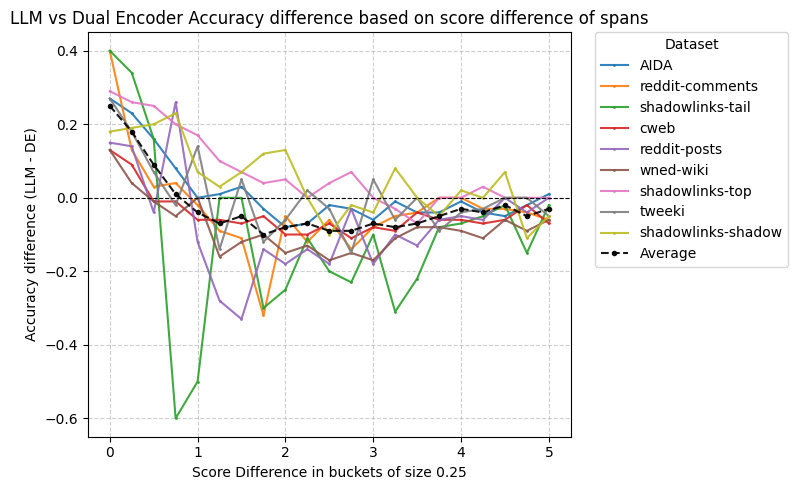

In [131]:
# --- Plot ---
plt.figure(figsize=(8, 5))

# Create a color palette for datasets
colors = plt.cm.tab10.colors
color_map = {dataset: colors[i % len(colors)] for i, dataset in enumerate(agg_data.keys())}


for dataset in datasets:
    buckets = []
    accuracies_de = []
    accuracies_llm = []
    accuracies_diff = []

    for bucket in agg_data[dataset].keys():
        if bucket == "above_max":
            continue
        buckets.append(float(bucket))
        accuracies_de.append(agg_data[dataset][bucket]["accuracy_de"])
        accuracies_llm.append(agg_data[dataset][bucket]["accuracy_llm"])
        accuracies_diff.append(agg_data[dataset][bucket]["accuracy_llm"] - agg_data[dataset][bucket]["accuracy_de"])

    base_color = color_map[dataset]
    
    #plt.plot(buckets, accuracies_de, marker="o", linestyle="--", color=base_color, alpha=0.3, markersize=3)
    #plt.plot(buckets, accuracies_llm, marker="o", label=dataset, color=base_color, alpha=0.9, markersize=5)

    plt.plot(buckets, accuracies_diff, marker="o", label=dataset, color=base_color, alpha=0.9, markersize=1)

avg_diffs = []
buckets = []    
for bucket in agg_data[list(agg_data.keys())[0]].keys():
    if bucket == "above_max":
        continue
    buckets.append(float(bucket))
    this_bucket_diffs = []
    for dataset in datasets:
        this_bucket_diffs.append(agg_data[dataset][bucket]["accuracy_llm"] - agg_data[dataset][bucket]["accuracy_de"])
    avg_diff = round(np.mean(this_bucket_diffs), 2)
    avg_diffs.append(avg_diff)

plt.plot(buckets, avg_diffs, marker="o", linestyle="--", label="Average", color="black", alpha=0.9, markersize=3)

    
# Aesthetics
plt.title(f"LLM vs Dual Encoder Accuracy difference based on score difference of spans")
plt.xlabel(f"Score Difference in buckets of size 0.25")
plt.ylabel(f"Accuracy difference (LLM - DE)")
plt.grid(True, linestyle="--", alpha=0.6)

# Legend outside the plot
plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()

plt.show()